In [33]:
from cyp_classifier import CYPClassifier
from pxr_regressor import PXRRegressor
from tdc.single_pred import ADME
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

Instantiate a CYP classifier

In [10]:
cyp_classifer = CYPClassifier('CYP_classifier.pkl')

Get the available models 

In [11]:
available_models = cyp_classifer.available_model_ids()
inhib_model_ids = [model_id for model_id in available_models if 'Inh' in model_id]
sub_model_ids = [model_id for model_id in available_models if 'Sub' in model_id]
inhib_model_ids, sub_model_ids

(['1A2_Inh', '2C19_Inh', '2C9_Inh', '2D6_Inh', '3A4_Inh'],
 ['1A2_Sub', '2C19_Sub', '2C9_Sub', '2D6_Sub', '3A4_Sub'])

Get the CYP data from the [Therapeutic Data Commons](https://tdcommons.ai/single_pred_tasks/adme/).  Note that some of this may overlap with the training sets. 

In [12]:
tdc_cyp_inhib_list = ['CYP2C19_Veith', 'CYP2C9_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith','CYP1A2_Veith']
inhib_df_list = []
for cyp_id in tdc_cyp_inhib_list:
    match = re.search(r'CYP([^_]+)', cyp_id)
    if match:
        name = match.group(1)
        model_id = f'{name}_Inh'
        dataset = ADME(cyp_id)
        df = dataset.get_data().copy()
        pred_list =cyp_classifer.predict_proba(model_id, df.Drug.tolist())
        df['pred'] = pred_list[:,1]
        df['dataset'] = cyp_id
        inhib_df_list.append(df)
    else:
        print(f"No match found for {cyp_id}")
inhib_combo_df = pd.concat(inhib_df_list)

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


The CYPClassier models return a probability between 0 and 1.0.  Prababilities closer to 1.0 indicate inhibitors, probabilities closer to 0 indicate nonihibitors. We use the plots below to look at classifier performance.  The box plots show the known CYP classification (1=inhibitor, 0=noninhibitor), the y-axis shows the probability predicted by the CYPClassifer. 

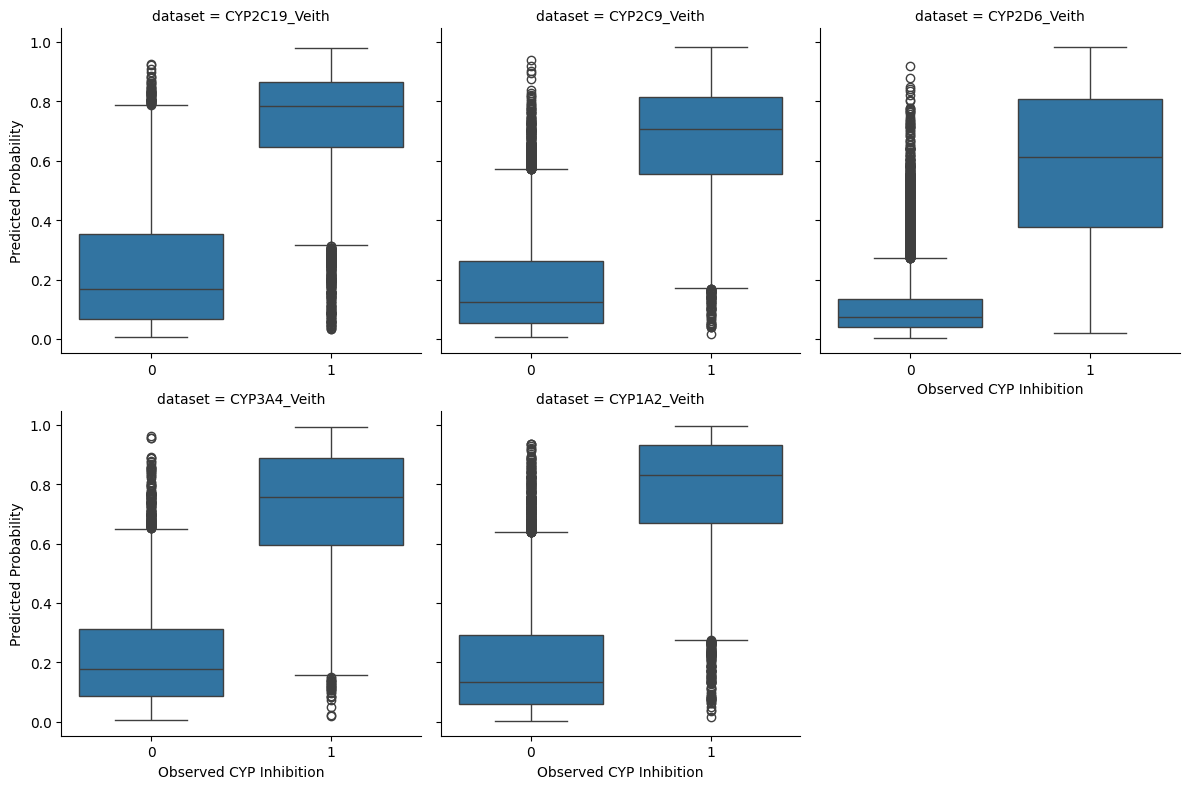

In [39]:
g = sns.FacetGrid(inhib_combo_df, col="dataset", col_wrap=3, sharex=False, sharey=True, height=4)
g.map(sns.boxplot, "Y", "pred")
g.set_axis_labels("Observed CYP Inhibition", "Predicted Probability")
g.fig.tight_layout()

We can do the same thing for CYP substrates.  In this case, a probability closer to 1 indicates a CYP substrate while a probability closer to 0 indicates a nonsubstrate. 

In [14]:
tdc_cyp_sub_list = ['CYP2C9_Substrate_CarbonMangels','CYP2D6_Substrate_CarbonMangels','CYP3A4_Substrate_CarbonMangels']
sub_df_list = []
for cyp_id in tdc_cyp_sub_list:
    match = re.search(r'CYP([^_]+)', cyp_id)
    if match:
        name = match.group(1)
        model_id = f'{name}_Sub'
        dataset = ADME(cyp_id)
        df = dataset.get_data().copy()
        pred_list = cyp_classifer.predict_proba(model_id, df.Drug.tolist())[:,1]
        df['pred'] = pred_list
        df['dataset'] = cyp_id
        sub_df_list.append(df)
    else:
        print(f"No match found for {cyp_id}")
sub_combo_df = pd.concat(sub_df_list)

Downloading...
100%|???????????????????????????????????????????????????????????????????????????????????| 45.6k/45.6k [00:00<00:00, 542kiB/s]
Loading...
Done!
Downloading...
100%|???????????????????????????????????????????????????????????????????????????????????| 45.4k/45.4k [00:00<00:00, 283kiB/s]
Loading...
Done!
Downloading...
100%|???????????????????????????????????????????????????????????????????????????????????| 46.0k/46.0k [00:00<00:00, 153kiB/s]
Loading...
Done!


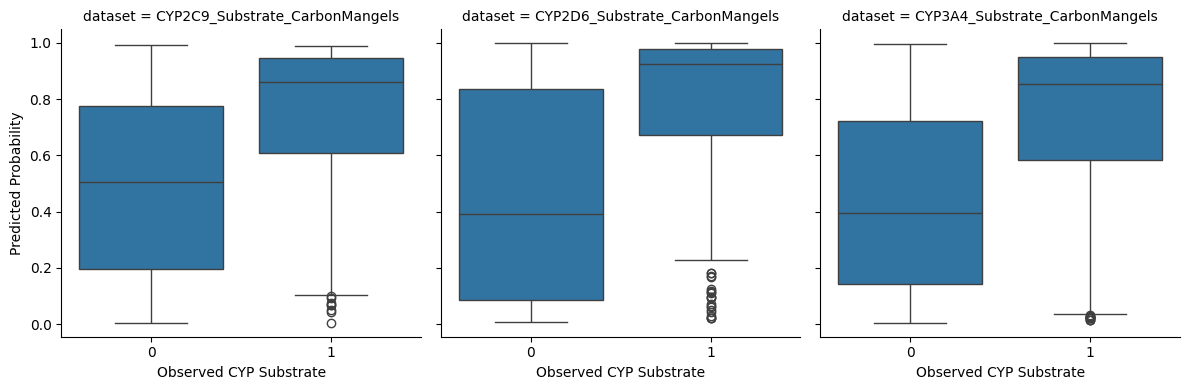

In [15]:
g = sns.FacetGrid(sub_combo_df, col="dataset", col_wrap=3, sharex=False, sharey=True, height=4)
g.map(sns.boxplot, "Y", "pred")
g.set_axis_labels("Observed CYP Substrate", "Predicted Probability")
g.fig.tight_layout()

The cells below demonstrate how to use the PXRRegressor.  This class takes a list of SMILES as an input and returns two arrays, the first has predictions and the second has the associated uncertainty. 

In [44]:
pxr_regressor = PXRRegressor("PXR_regressor.pkl")

In [45]:
predictions, uncertainty = pxr_regressor.predict(sub_combo_df.Drug)

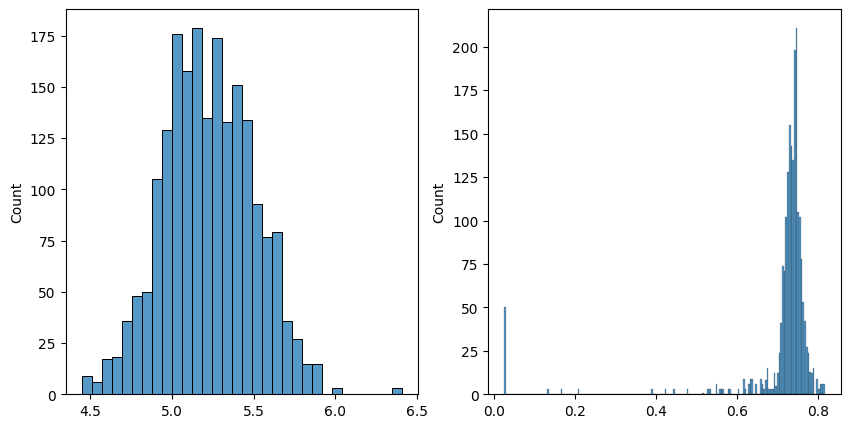

In [46]:
figure, axes = plt.subplots(1,2,figsize=(10,5),sharex=False,sharey=False)
ax0 = sns.histplot(predictions,ax=axes[0])
ax1 = sns.histplot(uncertainty,ax=axes[1])